In [1]:
%load_ext autoreload
%autoreload 2

# Load libraries and sample data

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


ticker_list = [
    "SPY",
    "GLD", 
    "TLT", 
    "DBA", 
    "DBB", 
    "USO",
]
price_data = {}
for ticker in ticker_list:
    # Load sample data
    df = pd.read_pickle(f'data/raw/price/{ticker}_20250201.pkl')
    df.set_index('Date', inplace=True)
    # data.index = pd.to_datetime(data.index, format="mixed")
    price_data[ticker] = df

# Trend following strategy

Trend following Results: {'cagr': 0.022534824129335718, 'volatility': 0.07754227326789609, 'sharpe': 0.29061340581906236, 'max_drawdown': 0.2370752010081961, 'cumulative_returns': 0.4300426438827638}


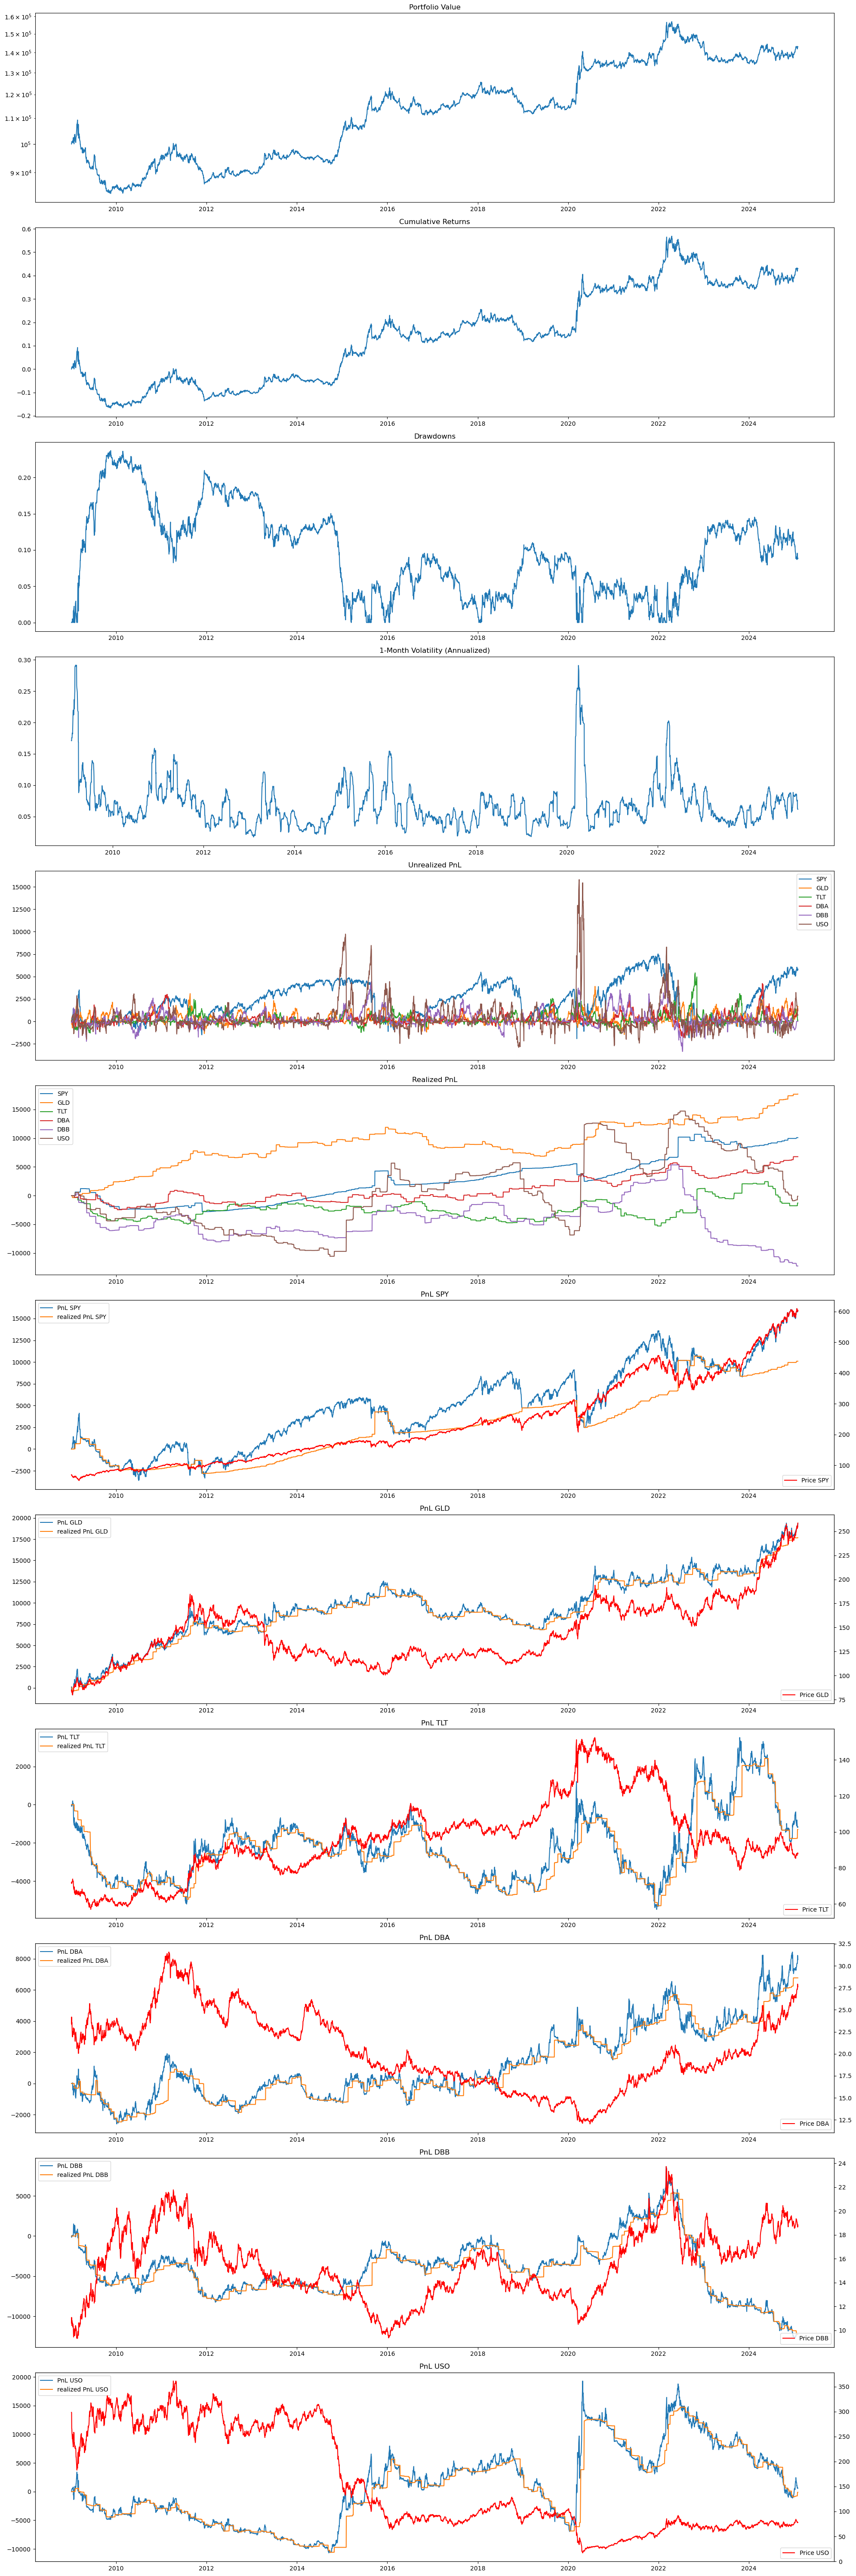

In [4]:
from strategies.trend_following import AdvancedTrendFollowingStrategy
from utils.backtester import BackTester

# Initialize backtester
bt = BackTester(price_data)
bt.add_strategy(
    AdvancedTrendFollowingStrategy, 
    tickers=ticker_list, 
    price_data=price_data, 
    fast_lookback=10,
    slow_lookback=400,
    rebalance_period=5,
    atr_period=21,
    correction_fast_weight={
        "SPY": 0.0
    },
    rebound_fast_weight={ticker: 0.8 for ticker in ticker_list},
    sma_trend_periods=(21, 252*2),
)
results = bt.backtest()
print("Trend following Results:", {k: v for k, v in results.items() if k != 'returns'})
bt.plot_results()

# Optuna

In [ ]:
import optuna

def optuna_study(ticker, df):
    ticker_list = [ticker]
    price_data = {ticker: df}

    def objective(trial):
        
        # Define the ranges for the numerical parameters
        fast_lookback = trial.suggest_int('fast_lookback', 5, 100)
        slow_lookback = trial.suggest_int('slow_lookback', 100, 252 * 2)
        # rebalance_period = trial.suggest_int('rebalance_period', 5, 21)
        # atr_period = trial.suggest_int('atr_period', 10, 50)
        rebalance_period = 21
        atr_period = 21
        
        # Define the ranges for the weights
        correction_fast_weight = {ticker: trial.suggest_float(f'correction_fast_weight_{ticker}', 0.0, 1.0) for ticker in ticker_list}
        rebound_fast_weight = {ticker: trial.suggest_float(f'rebound_fast_weight_{ticker}', 0.0, 1.0) for ticker in ticker_list}

        # Initialize the BackTester
        bt = BackTester(price_data)
        
        # Add the strategy with the suggested parameters
        bt.add_strategy(
            AdvancedTrendFollowingStrategy, 
            tickers=ticker_list, 
            price_data=price_data, 
            fast_lookback=fast_lookback,
            slow_lookback=slow_lookback,
            rebalance_period=rebalance_period,
            atr_period=atr_period,
            correction_fast_weight=correction_fast_weight,
            rebound_fast_weight=rebound_fast_weight,
            sma_trend_periods=(21, 252),
        )
        
        # Run the backtest
        results = bt.backtest()

        return results['sharpe']

    # Create a study object and optimize the objective function
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

    # Output the best parameters
    print(study.best_params)

    study.trials_dataframe().to_csv(f'optuna_study_results_{ticker}.csv')

for ticker in tqdm(ticker_list):
    optuna_study(ticker, price_data[ticker])

[autoreload of strategies.trend_following failed: Traceback (most recent call last):
  File "c:\Users\alexr\miniconda3\envs\ai\Lib\site-packages\IPython\extensions\autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\alexr\miniconda3\envs\ai\Lib\site-packages\IPython\extensions\autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "c:\Users\alexr\miniconda3\envs\ai\Lib\site-packages\IPython\extensions\autoreload.py", line 393, in update_generic
    update(a, b)
  File "c:\Users\alexr\miniconda3\envs\ai\Lib\site-packages\IPython\extensions\autoreload.py", line 345, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\alexr\miniconda3\envs\ai\Lib\site-packages\IPython\extensions\autoreload.py", line 393, in update_generic
    update(a, b)
  File "c:\Users\alexr\miniconda3\envs\ai\Lib\site-packages\IPython\extensions\autoreload.py", line 361, in update_cl

  0%|          | 0/6 [00:00<?, ?it/s]

[I 2025-02-02 19:37:48,622] A new study created in memory with name: no-name-220f4065-b9f5-490a-9521-cb2dcef3aea8
[I 2025-02-02 19:37:52,545] Trial 0 finished with value: 0.45391696395124 and parameters: {'fast_lookback': 59, 'slow_lookback': 152, 'correction_fast_weight_SPY': 0.44646273519256874, 'rebound_fast_weight_SPY': 0.7875020724235892}. Best is trial 0 with value: 0.45391696395124.
[I 2025-02-02 19:37:56,390] Trial 1 finished with value: 0.3412947913805696 and parameters: {'fast_lookback': 87, 'slow_lookback': 428, 'correction_fast_weight_SPY': 0.7108458544872747, 'rebound_fast_weight_SPY': 0.6061940874196174}. Best is trial 0 with value: 0.45391696395124.
[I 2025-02-02 19:38:00,307] Trial 2 finished with value: 0.34781363188097464 and parameters: {'fast_lookback': 19, 'slow_lookback': 176, 'correction_fast_weight_SPY': 0.8103843251164639, 'rebound_fast_weight_SPY': 0.20695522109328368}. Best is trial 0 with value: 0.45391696395124.


In [10]:
for ticker in ticker_list:
    print('---')
    print(ticker)
    df = pd.read_csv(f'./optuna_study_results_{ticker}.csv')
    df.sort_values(by='value', ascending=False, inplace=True)
    print(df .iloc[0])

---
SPY
Unnamed: 0                                               84
number                                                   84
value                                              0.639993
datetime_start                                      58:40.4
datetime_complete                                   58:44.6
duration                             0 days 00:00:04.177050
params_correction_fast_weight_SPY                  0.053491
params_fast_lookback                                     10
params_rebound_fast_weight_SPY                     0.818403
params_slow_lookback                                    250
state                                              COMPLETE
Name: 0, dtype: object
---
GLD
Unnamed: 0                                               93
number                                                   93
value                                              0.498432
datetime_start                                      03:47.8
datetime_complete                                   03:50.4
d

# Effect of lookback period

In [4]:
X = range(5, 252)
y = []
for x in tqdm(X):
    bt = BackTester(price_data)
    bt.add_strategy(TrendFollowingStrategy, tickers=['SPY'], price_data=price_data, lookback=x)
    results = bt.backtest()
    y.append(results)

plt.plot(X, [f['cagr'] for f in y])
plt.title('CAGR vs. Lookback Period')
plt.xlabel('Lookback Period')
plt.ylabel('CAGR')
plt.show()


plt.plot(X, [f['volatility'] for f in y])
plt.title('Volatility vs. Lookback Period')
plt.xlabel('Lookback Period')
plt.ylabel('Volatility')
plt.show()


plt.plot(X, [f['sharpe'] for f in y])
plt.title('Sharpe vs. Lookback Period')
plt.xlabel('Lookback Period')
plt.ylabel('Sharpe')
plt.show()


plt.plot(X, [f['max_drawdown'] for f in y])
plt.title('Max Drawdown vs. Lookback Period')
plt.xlabel('Lookback Period')
plt.ylabel('Max Drawdown')
plt.show()


  0%|          | 0/247 [00:00<?, ?it/s]

NameError: name 'TrendFollowingStrategy' is not defined